This file contains the model for text training. It is based on the code from the hyperparameter tuning, in order to replicate the results obtained in hyperparam tuning as closely as possible - did not work!! completely different results.
Only the last layer is trained!! To train all layer remove the for loop setting require_grad to false (cell 4) and change model.classifier.parameters() to model.parameters() inside the optimizer (cell 4).

In [2]:
from functions_text_model import *
import os
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import random_split
from sklearn.model_selection import ParameterGrid

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)

In [4]:
# Set hyperparameters
learning_rate = 0.0001
num_epochs = 5
batch_size = 16

In [5]:
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Create a new model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.1),
    nn.Linear(in_features=768, out_features=512, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=128, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=128, out_features=2, bias=True)
    )


#for parameter in model.bert.parameters():    # Remove if training the entire model
#    parameter.requires_grad_ = False

model.to(device)

# Create a new optimizer with the current learning rate
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)  #model.classifier.parameters()


# Create the optimizer  
criterion = nn.CrossEntropyLoss()

metrics = {'ACC': acc, 'F1-weighted': f1}
# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#model

In [7]:
#model.classifier.weight

train Loss: 0.6605,  ACC: 0.6411, F1-weighted: 0.5979


100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


eval Loss: 0.6086,  ACC: 0.7208, F1-weighted: 0.7106


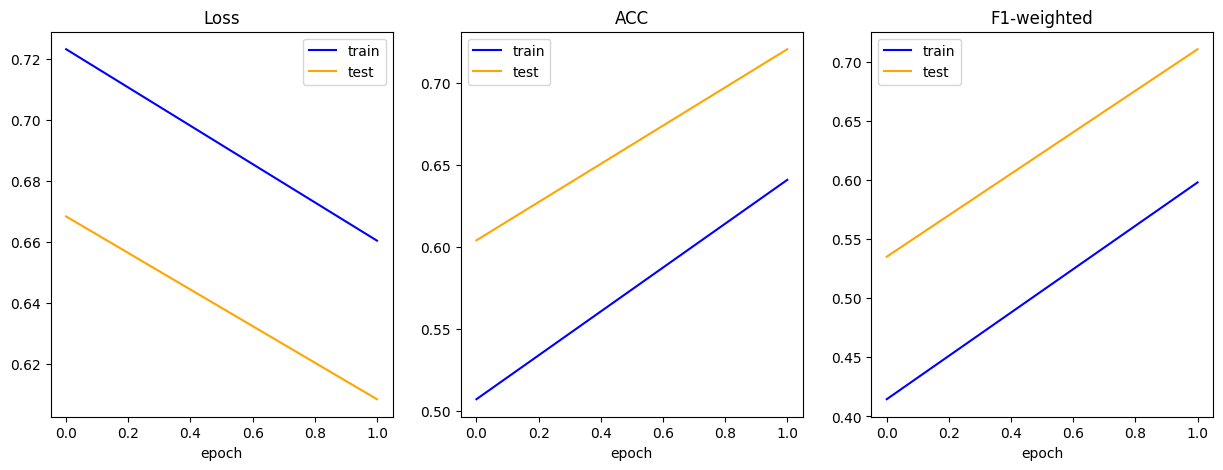

Epoch 3


 37%|███▋      | 13/35 [02:25<04:06, 11.20s/it]


KeyboardInterrupt: 

In [8]:
# Train and evaluate the model for the current number of epochs
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(20):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_dataloader, device)

    test_loss, test_metrics = evaluate(model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    #print('train metrics', train_metrics)
    #print('test metrics', eval_metrics)

print("train loss", train_loss_log, "test loss", test_loss_log)

In [9]:
model.classifier.weight

Parameter containing:
tensor([[ 0.0388,  0.0286,  0.0190,  ..., -0.0321, -0.0069,  0.0079],
        [ 0.0066, -0.0609, -0.0302,  ...,  0.0045,  0.0048,  0.0300]],
       requires_grad=True)

In [ ]:
# Save the entire model
torch.save(model.state_dict(), 'text-model-BERT.pth')